<a href="https://colab.research.google.com/github/elephant2015/Code4PollutantsBiLSTM/blob/main/fourier_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datatransf/transformed_data.csv


In [ ]:
!pip install keras-tuner


In [ ]:
from keras_tuner import HyperModel, HyperParameters

def build_lstm_with_tuning(hp):
    model = Sequential()
    model.add(
        Bidirectional(
            LSTM(
                units=hp.Int("units_1", min_value=128, max_value=512, step=64),
                return_sequences=True,
                input_shape=(X_train_residuals.shape[1], 1),
            )
        )
    )
    model.add(Dropout(hp.Float("dropout_1", min_value=0.1, max_value=0.5, step=0.1)))
    model.add(
        Bidirectional(
            LSTM(
                units=hp.Int("units_2", min_value=64, max_value=256, step=32),
                return_sequences=False,
            )
        )
    )
    model.add(Dense(hp.Int("dense_units", min_value=64, max_value=256, step=32), activation="relu"))
    model.add(Dropout(hp.Float("dropout_2", min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation="linear"))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])
        ),
        loss=tf.keras.losses.Huber(delta=1.0),
    )
    return model


In [ ]:
from keras_tuner.tuners import RandomSearch

tuner = RandomSearch(
    build_lstm_with_tuning,
    objective="val_loss",
    max_trials=10,  # Numărul maxim de combinații de hiperparametri de testat
    executions_per_trial=2,  # Numărul de execuții per combinație de hiperparametri
    directory="tuner_results22",
    project_name="sarima_lstm_tuning",
)

# Pregătirea datelor
X_train_residuals = X_train_residuals.reshape((X_train_residuals.shape[0], X_train_residuals.shape[1], 1))

# Căutarea celor mai buni hiperparametri
tuner.search(
    X_train_residuals,
    y_train_residuals,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[EarlyStopping(monitor="val_loss", patience=5)],
)


Trial 10 Complete [00h 00m 30s]
val_loss: 0.0005778551567345858

Best val_loss So Far: 0.0005750204436480999
Total elapsed time: 00h 06m 38s


In [ ]:
# Obține cel mai bun set de hiperparametri
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of units in the first LSTM layer is {best_hps.get('units_1')},
the optimal number of units in the second LSTM layer is {best_hps.get('units_2')},
the optimal dropout rates are {best_hps.get('dropout_1')} and {best_hps.get('dropout_2')},
and the optimal learning rate is {best_hps.get('learning_rate')}.
""")

# Obține cel mai bun model și antrenează-l pe întreaga dată de antrenament
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(
    X_train_residuals, y_train_residuals,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=[EarlyStopping(monitor="val_loss", patience=10)],
)



The optimal number of units in the first LSTM layer is 512,
the optimal number of units in the second LSTM layer is 192,
the optimal dropout rates are 0.2 and 0.1,
and the optimal learning rate is 0.01.

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 0.4274 - val_loss: 0.0029
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0031 - val_loss: 8.3453e-04
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 8.2550e-04 - val_loss: 5.8653e-04
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 7.4260e-04 - val_loss: 5.8240e-04
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 7.1118e-04 - val_loss: 5.7629e-04
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 6.8507e-04 - val_loss: 6.1211e-04
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 6.8864e-04 - val_loss: 6.1069e-04
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 6.8195e-04 - val_loss: 5.7423e-04
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - l

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import boxcox
import tensorflow as tf

# Preprocessing data
def preprocess_data(file_path):
    data = pd.read_csv(file_path)
    data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%y')
    data = data.sort_values(by='Date')
    data.set_index('Date', inplace=True)

    # Apply Box-Cox transformation
    transformed_data = pd.DataFrame(index=data.index)
    lambda_values = {}
    for column in data.columns:
        positive_values = data[column] + abs(data[column].min()) + 1
        transformed_data[column], lambda_values[column] = boxcox(positive_values)

    return data, transformed_data, lambda_values

# Generate Fourier terms
def generate_fourier_terms(data, periods, order):
    """Generate Fourier terms for given periods and order."""
    time = np.arange(len(data))
    fourier_terms = pd.DataFrame(index=data.index)
    for period in periods:
        for k in range(1, order + 1):
            fourier_terms[f'sin_{k}_{period}'] = np.sin(2 * np.pi * k * time / period)
            fourier_terms[f'cos_{k}_{period}'] = np.cos(2 * np.pi * k * time / period)
    return fourier_terms

# Function to create sequences for LSTM
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

# Define LSTM model
def build_lstm(input_shape):
    model = Sequential([
        Bidirectional(LSTM(256, return_sequences=True, input_shape=input_shape)),
        Dropout(0.2),
        Bidirectional(LSTM(128, return_sequences=False)),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='linear')
    ])
    optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5)
    loss = tf.keras.losses.Huber(delta=1.0)
    model.compile(optimizer=optimizer, loss=loss)
    return model

# Evaluate metrics
def evaluate_metrics(actual, forecast):
    rmse = mean_squared_error(actual, forecast, squared=False)
    mae = mean_absolute_error(actual, forecast)
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100
    return rmse, mae, mape

# File path and data preparation
file_path = '../input/datatransf/transformed_data.csv'
data, transformed_data, lambda_values = preprocess_data(file_path)

# Generate Fourier terms
periods = [12]  # Monthly seasonality
order = 6  # Number of Fourier terms
fourier_terms = generate_fourier_terms(transformed_data, periods, order)

# Split into train and test sets
test_size_days = 180  # Last 6 months for test
train_data = transformed_data.iloc[:-test_size_days]
test_data = transformed_data.iloc[-test_size_days:]
fourier_train = fourier_terms.iloc[:-test_size_days]
fourier_test = fourier_terms.iloc[-test_size_days:]

# Train SARIMA and generate predictions
def train_sarima(data, order, seasonal_order, exog):
    model = SARIMAX(data, order=order, seasonal_order=seasonal_order, exog=exog)
    sarima_fit = model.fit(disp=False)
    predictions = sarima_fit.fittedvalues
    return sarima_fit, predictions

# SARIMA configuration
sarima_order = (2, 1, 1)
seasonal_order = (0, 0, 0, 12)

# Train SARIMA
sarima_model, sarima_predictions_train = train_sarima(
    train_data['NO2'], sarima_order, seasonal_order, exog=fourier_train
)

# Forecast SARIMA on the test set
sarima_predictions_test = sarima_model.forecast(
    steps=len(test_data), exog=fourier_test
)
sarima_predictions = pd.concat(
    [sarima_predictions_train, pd.Series(sarima_predictions_test, index=test_data.index)]
)

# Compute SARIMA residuals
residuals = train_data['NO2'] - sarima_predictions_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_residuals = scaler.fit_transform(residuals.values.reshape(-1, 1))

# Generate sequences for LSTM
time_steps = 90
X_train_residuals, y_train_residuals = create_sequences(scaled_residuals, time_steps)

# Check if the test set contains sufficient sequences
test_residuals = test_data['NO2'] - sarima_predictions_test
scaled_test_residuals = scaler.transform(test_residuals.values.reshape(-1, 1))
X_test_residuals, _ = create_sequences(scaled_test_residuals, time_steps)

if len(X_test_residuals) == 0:
    raise ValueError("Not enough data in the test set to create sequences for LSTM. Increase the test set size.")

# Build and train LSTM
model_lstm = build_lstm((X_train_residuals.shape[1], 1))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

model_lstm.fit(
    X_train_residuals, y_train_residuals,
    validation_split=0.2,
    epochs=100, batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)

# Predict residuals with LSTM
lstm_predictions = model_lstm.predict(X_test_residuals)
lstm_predictions_rescaled = scaler.inverse_transform(lstm_predictions.reshape(-1, 1))

# Combine SARIMA predictions and LSTM corrections
min_length = min(len(sarima_predictions_test), len(lstm_predictions_rescaled))
sarima_predictions_aligned_trimmed = sarima_predictions_test[-min_length:]
lstm_predictions_rescaled_trimmed = lstm_predictions_rescaled.flatten()[:min_length]

final_predictions_lstm = sarima_predictions_aligned_trimmed.values + lstm_predictions_rescaled_trimmed

# Evaluate metrics
test_actual_values_trimmed = test_data['NO2'][-min_length:]
metrics_lstm = evaluate_metrics(test_actual_values_trimmed, final_predictions_lstm)
metrics_sarima = evaluate_metrics(test_actual_values_trimmed, sarima_predictions_aligned_trimmed)

# Print metrics
print(f"SARIMA Metrics: RMSE={metrics_sarima[0]:.3f}, MAE={metrics_sarima[1]:.3f}, MAPE={metrics_sarima[2]:.2f}%")
print(f"Hybrid (SARIMA + LSTM) Metrics: RMSE={metrics_lstm[0]:.3f}, MAE={metrics_lstm[1]:.3f}, MAPE={metrics_lstm[2]:.2f}%")




/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0130 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0041 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0037 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0036 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0040 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0037 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0035 - val_loss: 0.0021 - learning_rate: 5.0000e-04
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0036 - val_loss: 0.0021 - learning_rate: 5.0000e-04
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0035 - val_loss: 0.0021 - learning_rate: 5.0000e-04
Epoch 10/1

In [ ]:
# Combine SARIMA predictions into a single DataFrame
sarima_predictions = pd.concat([
    pd.Series(sarima_predictions_train, index=train_data.index),
    pd.Series(sarima_predictions_test, index=test_data.index)
], axis=0).rename("PM25").reset_index()
sarima_predictions.columns = ['Date', 'PM25']

# Save SARIMA predictions
sarima_predictions.to_csv('sarima_predictions.csv', index=False)

# Save LSTM predictions
lstm_predictions_rescaled_df = pd.DataFrame({
    'Date': test_data.index[-len(lstm_predictions_rescaled):],
    'PM25': lstm_predictions_rescaled.flatten()
})
lstm_predictions_rescaled_df.to_csv('lstm_predictions.csv', index=False)

# Save Hybrid predictions
hybrid_predictions_df = pd.DataFrame({
    'Date': test_data.index[-len(final_predictions_lstm):],
    'PM25': final_predictions_lstm
})
hybrid_predictions_df.to_csv('hybrid_predictions.csv', index=False)


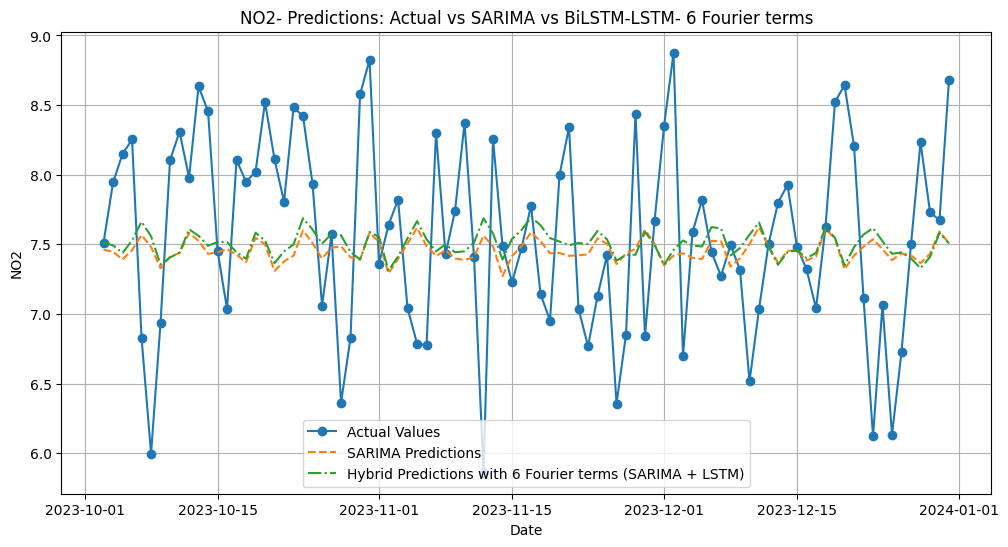

In [ ]:
# Plot Actual vs Predictions
plt.figure(figsize=(12, 6))
plt.plot(test_actual_values_trimmed.index, test_actual_values_trimmed, label='Actual Values', marker='o', linestyle='-')
plt.plot(test_actual_values_trimmed.index, sarima_predictions_test[-len(test_actual_values_trimmed):], label='SARIMA Predictions', linestyle='--')
plt.plot(test_actual_values_trimmed.index, final_predictions_lstm, label='Hybrid Predictions with 6 Fourier terms (SARIMA + LSTM)', linestyle='-.')
plt.title("NO2- Predictions: Actual vs SARIMA vs BiLSTM-LSTM- 6 Fourier terms")
plt.xlabel("Date")
plt.ylabel("NO2")
plt.legend()
plt.grid(True)
plt.savefig('no2_fourier.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
def predict_and_evaluate(model, sarima_model, scaler, test_data, time_steps, horizon, feature_name='PM25'):
    """
    Predict for a given horizon using the hybrid SARIMA + LSTM model.
    Args:
        model: Trained LSTM model.
        sarima_model: Trained SARIMA model.
        scaler: Scaler used for residuals.
        test_data: Test dataset.
        time_steps: Number of time steps for LSTM sequences.
        horizon: Number of steps ahead to forecast.
        feature_name: Name of the feature being forecasted.

    Returns:
        RMSE, MAE, MAPE for the given horizon.
    """
    hybrid_forecasts = []  # Store hybrid forecasts
    actual_values = []  # Store actual values

    for i in range(horizon, len(test_data) - horizon):
        # Get SARIMA forecast for the current horizon
        sarima_forecast = sarima_model.forecast(steps=horizon)

        # Calculate SARIMA residuals
        actual = test_data[feature_name].iloc[i:i + horizon].values
        residuals = actual - sarima_forecast

        # Scale residuals
        scaled_residuals = scaler.transform(residuals.to_numpy().reshape(-1, 1))


        # Create LSTM input sequence from scaled residuals
        X_seq, _ = create_sequences(scaled_residuals, time_steps)

        if len(X_seq) > 0:
            # Make LSTM predictions
            lstm_predictions = model.predict(X_seq)
            lstm_rescaled = scaler.inverse_transform(lstm_predictions.reshape(-1, 1))

            # Combine SARIMA and LSTM forecasts
            hybrid_forecast = sarima_forecast[-1] + lstm_rescaled[-1][0]
        else:
            # If not enough data for LSTM, use SARIMA alone
            hybrid_forecast = sarima_forecast[-1]

        # Append results
        hybrid_forecasts.append(hybrid_forecast)
        actual_values.append(actual[-1])  # Use the last value of the actual horizon

    # Convert to numpy arrays
    hybrid_forecasts = np.array(hybrid_forecasts)
    actual_values = np.array(actual_values)

    # Calculate metrics
    rmse, mae, mape = evaluate_metrics(actual_values, hybrid_forecasts)

    return rmse, mae, mape


In [ ]:
time_steps = 1  # Deja utilizat, dar poate fi ajustat fin
  # Minim pentru secvențe
test_size_days = 720  # Creștem dimensiunea setului de test
train_data = transformed_data.iloc[:-test_size_days]
test_data = transformed_data.iloc[-test_size_days:]
horizons = [1, 7, 30]  # Ajustăm orizonturile
# Generăm termenii Fourier pentru întregul set de test (720 zile)
fourier_test = generate_fourier_terms(data.iloc[-test_size_days:], periods, order)

for horizon in horizons:
    print(f"\nProcessing Horizon: {horizon} day(s)")
    time_steps = max(1, horizon // 2)  # Ajustăm dimensiunea secvențelor în funcție de orizont

    # Generăm predicțiile SARIMA pentru întreg setul de test
    sarima_predictions_test = sarima_model.forecast(steps=len(test_data),exog=fourier_test)
    residuals_test = test_data['PM25'] - sarima_predictions_test
    residuals_test = residuals_test.dropna()

    if len(residuals_test) < time_steps:
        print(f"Not enough residuals for Horizon {horizon}. Using SARIMA predictions only.")
        actual_values = test_data['PM25'][:len(sarima_predictions_test)]
        final_predictions = sarima_predictions_test
        rmse, mae, mape = evaluate_metrics(actual_values, final_predictions)
        print(f"Horizon: {horizon} day(s) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, MAPE: {mape:.2f}%")
        continue

    # Generăm secvențe pentru predicția reziduurilor
    scaled_residuals_test = scaler.transform(residuals_test.values.reshape(-1, 1))
    X_test_residuals, _ = create_sequences(scaled_residuals_test.ravel(), time_steps)
    X_test_residuals = X_test_residuals.reshape((X_test_residuals.shape[0], X_test_residuals.shape[1], 1))

    if len(X_test_residuals) == 0:
        print(f"No sequences generated for Horizon {horizon}. Skipping.")
        continue

    # Predictii cu modelul optimizat
    lstm_predictions = model_lstm.predict(X_test_residuals)

    # Reducem dimensiunea predicțiilor la ultima valoare
    lstm_predictions = lstm_predictions[:, -1]

    # Rescalăm predicțiile pentru a reveni la domeniul original
    lstm_predictions_rescaled = scaler.inverse_transform(lstm_predictions.reshape(-1, 1)).flatten()

    # Ajustăm dimensiunile pentru alinierea SARIMA și LSTM
    min_length = min(len(sarima_predictions_test), len(lstm_predictions_rescaled))
    sarima_predictions_trimmed = sarima_predictions_test[:min_length]
    lstm_predictions_trimmed = lstm_predictions_rescaled[:min_length]

    # Combinăm predicțiile SARIMA și LSTM
    final_predictions = sarima_predictions_trimmed.values + lstm_predictions_trimmed

    # Ajustăm dimensiunile pentru evaluare
    actual_values = test_data['PM25'][:min_length].values
    final_predictions = final_predictions[:min_length]

    # Calculăm metricele pentru orizontul curent
    rmse, mae, mape = evaluate_metrics(actual_values, final_predictions)
    print(f"Horizon: {horizon} day(s) -> RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.4f}%")



Processing Horizon: 1 day(s)
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
Horizon: 1 day(s) -> RMSE: 0.1737, MAE: 0.1574, MAPE: 10.4273%

Processing Horizon: 7 day(s)
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Horizon: 7 day(s) -> RMSE: 0.1370, MAE: 0.1179, MAPE: 7.7750%

Processing Horizon: 30 day(s)
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Horizon: 30 day(s) -> RMSE: 0.1004, MAE: 0.0801, MAPE: 5.2898%


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Reziduuri - Metrici:
  SARIMA: RMSE=0.000, MAE=0.000, MAPE=0.00%
  BiLSTM: RMSE=0.645, MAE=0.624, MAPE=99.13%


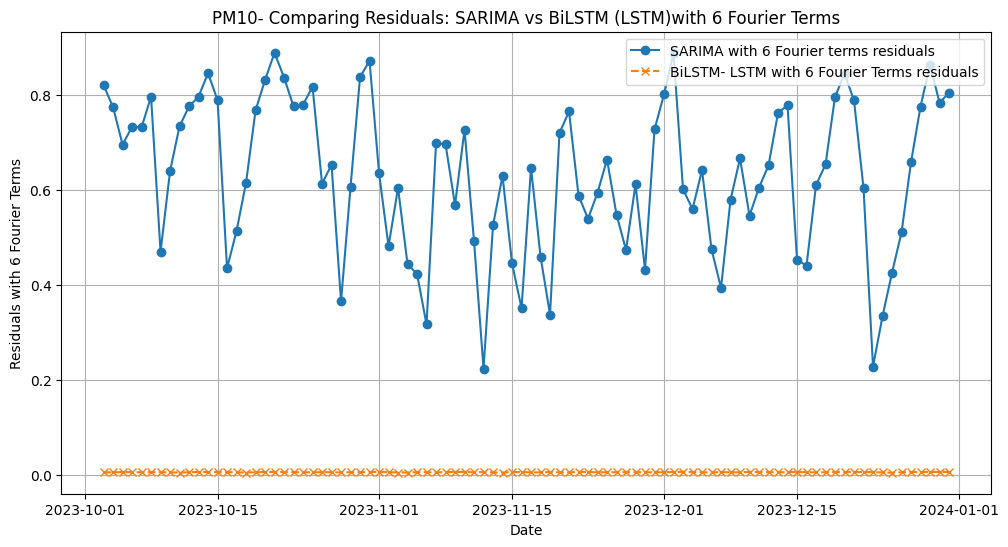

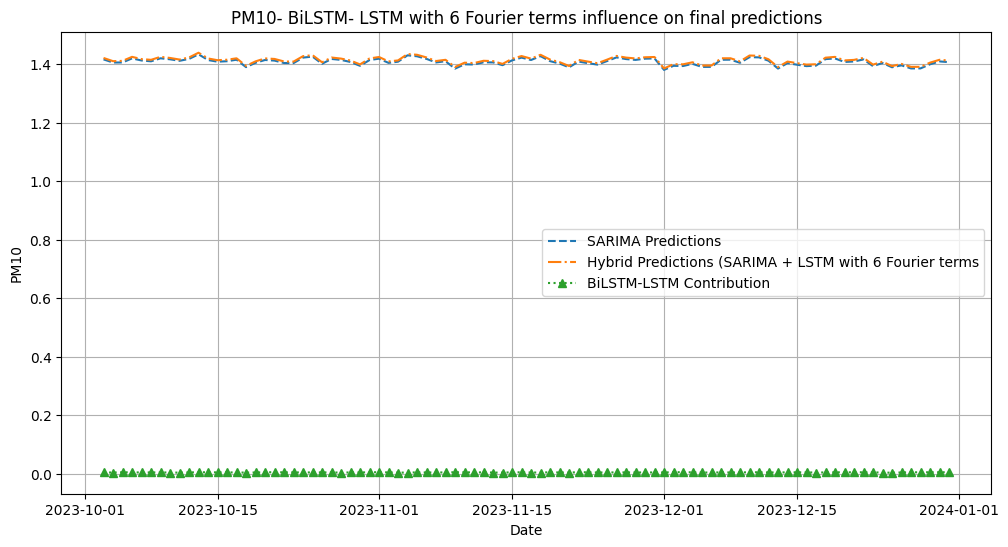

In [ ]:
# Analiza rezidualelor SARIMA
residuals_test = test_data['PM10'] - sarima_predictions_test
scaled_residuals_test = scaler.transform(residuals_test.values.reshape(-1, 1))

# Predicțiile rezidualelor cu LSTM
lstm_residuals_predictions = best_model.predict(X_test_residuals)
lstm_residuals_predictions_rescaled = scaler.inverse_transform(lstm_residuals_predictions)

# Ajustarea lungimii pentru aliniere între reziduuri SARIMA și predicții LSTM
min_length = min(len(residuals_test), len(lstm_residuals_predictions_rescaled))
residuals_test_trimmed = residuals_test[-min_length:]
lstm_predictions_rescaled_trimmed = lstm_residuals_predictions_rescaled.flatten()[:min_length]

# Metrici pentru reziduurile SARIMA și BiLSTM
metrics_residuals_sarima = evaluate_metrics(
    residuals_test_trimmed,
    residuals_test_trimmed
)
metrics_residuals_lstm = evaluate_metrics(
    residuals_test_trimmed,
    lstm_predictions_rescaled_trimmed
)

# Afișăm metricile pentru reziduuri
print("\nReziduuri - Metrici:")
print(f"  SARIMA: RMSE={metrics_residuals_sarima[0]:.3f}, MAE={metrics_residuals_sarima[1]:.3f}, MAPE={metrics_residuals_sarima[2]:.2f}%")
print(f"  BiLSTM: RMSE={metrics_residuals_lstm[0]:.3f}, MAE={metrics_residuals_lstm[1]:.3f}, MAPE={metrics_residuals_lstm[2]:.2f}%")

# Grafic pentru reziduuri
plt.figure(figsize=(12, 6))
plt.plot(
    residuals_test_trimmed.index,
    residuals_test_trimmed,
    label='SARIMA with 6 Fourier terms residuals', linestyle='-', marker='o'
)
plt.plot(
    residuals_test_trimmed.index,
    lstm_predictions_rescaled_trimmed,
    label='BiLSTM- LSTM with 6 Fourier Terms residuals', linestyle='--', marker='x'
)
plt.title("PM10- Comparing Residuals: SARIMA vs BiLSTM (LSTM)with 6 Fourier Terms")
plt.xlabel("Date")
plt.ylabel("Residuals with 6 Fourier Terms")
plt.legend()
plt.grid(True)
plt.show()

# Grafic pentru influența BiLSTM asupra predicțiilor hibride
contribution_lstm = lstm_predictions_rescaled_trimmed
plt.figure(figsize=(12, 6))
plt.plot(
    test_actual_values_trimmed.index,
    sarima_predictions_aligned_trimmed,
    label='SARIMA Predictions', linestyle='--'
)
plt.plot(
    test_actual_values_trimmed.index,
    final_predictions_lstm,
    label='Hybrid Predictions (SARIMA + LSTM with 6 Fourier terms', linestyle='-.'
)
plt.plot(
    test_actual_values_trimmed.index,
    contribution_lstm,
    label='BiLSTM-LSTM Contribution', linestyle=':', marker='^'
)
plt.title("PM10- BiLSTM- LSTM with 6 Fourier terms influence on final predictions")
plt.xlabel("Date")
plt.ylabel("PM10")
plt.legend()
plt.grid(True)
plt.savefig('no2_f2predictions.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
residuals_sarima = test_data['NO2'][-min_length:] - sarima_predictions_aligned_trimmed
residuals_hybrid = test_data['NO2'][-min_length:] - final_predictions_lstm

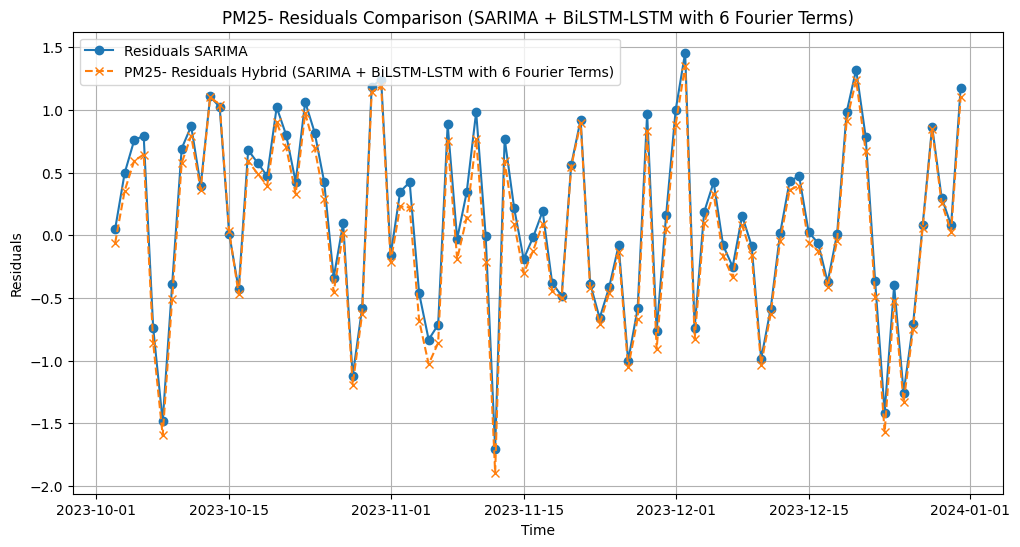

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(residuals_sarima, label='Residuals SARIMA', linestyle='-', marker='o')
plt.plot(residuals_hybrid, label='PM25- Residuals Hybrid (SARIMA + BiLSTM-LSTM with 6 Fourier Terms)', linestyle='--', marker='x')
plt.title("PM25- Residuals Comparison (SARIMA + BiLSTM-LSTM with 6 Fourier Terms)")
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.legend()
plt.grid(True)
plt.savefig('pm25_residuals_comparisfon.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import skew, kurtosis
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import acf, q_stat
def calculate_residual_metrics(residuals, model_name="Model"):
    if len(residuals) < 10:
        print(f"Not enough data for Ljung-Box test in {model_name}. Skipping...")
        return {
            'Model': model_name,
            'Mean': np.mean(residuals),
            'Std Dev': np.std(residuals),
            'Skewness': skew(residuals, nan_policy='omit'),
            'Kurtosis': kurtosis(residuals, nan_policy='omit'),
            'Durbin-Watson': np.nan,
            'Ljung-Box p-value': np.nan
        }

    # Calculate metrics
    mean_residual = np.mean(residuals)
    std_residual = np.std(residuals)
    skewness_residual = skew(residuals, nan_policy='omit')
    kurtosis_residual = kurtosis(residuals, nan_policy='omit')

    # Durbin-Watson statistic
    durbin_watson_stat = durbin_watson(residuals)

    # Ljung-Box test
    try:
        ljung_box_df = acorr_ljungbox(residuals, lags=[10], return_df=True)
        ljung_box_p_value = ljung_box_df['lb_pvalue'].iloc[0]
    except Exception as e:
        ljung_box_p_value = np.nan
        print(f"Error calculating Ljung-Box for {model_name}: {e}")

    metrics = {
        'Model': model_name,
        'Mean': mean_residual,
        'Std Dev': std_residual,
        'Skewness': skewness_residual,
        'Kurtosis': kurtosis_residual,
        'Durbin-Watson': durbin_watson_stat,
        'Ljung-Box p-value': ljung_box_p_value
    }
    return metrics
# Alinierea lungimilor între SARIMA și LSTM
min_length = min(len(sarima_predictions_test), len(lstm_predictions_rescaled))
sarima_predictions_aligned = sarima_predictions_test[-min_length:]
lstm_predictions_rescaled_trimmed = lstm_predictions_rescaled.flatten()[:min_length]

# Calcularea predicțiilor hibride
final_predictions_bilstm = sarima_predictions_aligned + lstm_predictions_rescaled_trimmed

# Calcularea reziduurilor
residuals_sarima = test_data['PM10'][-min_length:] - sarima_predictions_aligned
residuals_hybrid = test_data['PM10'][-min_length:] - final_predictions_bilstm

metrics_sarima = calculate_residual_metrics(residuals_sarima, model_name="SARIMA")
metrics_hybrid = calculate_residual_metrics(residuals_hybrid, model_name="SARIMA + BiLSTM")
# Recalculăm metricile folosind funcția corectată

# Combinați metricile într-un DataFrame și afișați
residuals_metrics = pd.DataFrame([metrics_sarima, metrics_hybrid])
print(residuals_metrics)

# Salvăm rezultatele într-un CSV
residuals_metrics.to_csv("residuals_metrics.csv", index=False)


             Model      Mean   Std Dev  Skewness  Kurtosis  Durbin-Watson  \
0           SARIMA  0.031658  0.163092 -0.446593 -0.598265       0.927530   
1  SARIMA + BiLSTM  0.001765  0.163098 -0.453789 -0.564732       0.961713   

   Ljung-Box p-value  
0       2.071605e-07  
1       3.947587e-07  


NaN values found in Hybrid Predictions. Filling missing values with SARIMA predictions.

SARIMA Performance on Extreme Values:
  RMSE: 0.313, MAE: 0.309, MAPE: 18.32%

SARIMA + BiLSTM Performance on Extreme Values:
  RMSE: 0.339, MAE: 0.335, MAPE: 19.85%

Metrics for Extreme Values:
             Model      RMSE       MAE       MAPE
0           SARIMA  0.312844  0.309307  18.317319
1  SARIMA + BiLSTM  0.339453  0.335237  19.853714


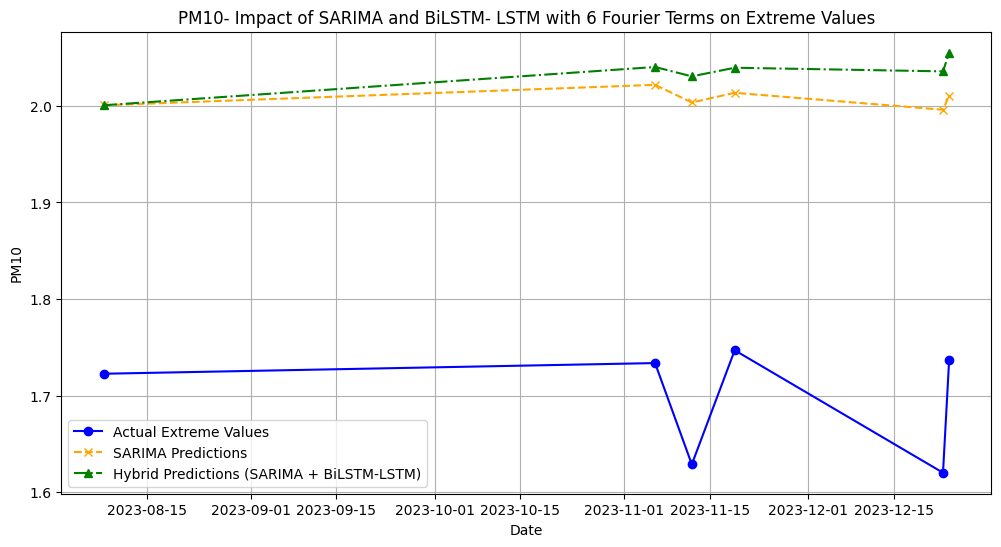

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculăm media și deviația standard
mean_pm10 = test_data['PM10'].mean()
std_pm10 = test_data['PM10'].std()

# Definim pragurile pentru valori extreme
upper_threshold = mean_pm10 + 2 * std_pm10
lower_threshold = mean_pm10 - 2 * std_pm10

# Convertim predicțiile SARIMA într-un DataFrame cu aceiași indici ca test_data['PM10']
sarima_predictions_df = pd.Series(sarima_predictions_test, index=test_data.index, name='SARIMA Predictions')

# Realiniem predicțiile hibride pentru a avea aceiași indici
hybrid_predictions_df = pd.Series(
    final_predictions_bilstm,
    index=test_data.index[-len(final_predictions_bilstm):],
    name='Hybrid Predictions'
).reindex(test_data.index)

# Verificăm și completăm valorile NaN în predicții
if hybrid_predictions_df.isna().any():
    print("NaN values found in Hybrid Predictions. Filling missing values with SARIMA predictions.")
    hybrid_predictions_df = hybrid_predictions_df.fillna(sarima_predictions_df)

# Identificăm valorile extreme din datele reale
extreme_actual = test_data['PM10'][(test_data['PM10'] > upper_threshold) | (test_data['PM10'] < lower_threshold)]

# Selectăm predicțiile SARIMA și hibride corespunzătoare valorilor extreme
extreme_sarima = sarima_predictions_df.loc[extreme_actual.index]
extreme_hybrid = hybrid_predictions_df.loc[extreme_actual.index]

# Verificăm și completăm valorile NaN pentru valorile extreme
if extreme_hybrid.isna().any():
    print("NaN values found in Extreme Hybrid Predictions. Filling missing values with SARIMA predictions.")
    extreme_hybrid = extreme_hybrid.fillna(extreme_sarima)

# Funcție pentru calcularea metricilor pentru valori extreme
def calculate_extreme_metrics(actual, prediction, model_name):
    rmse = mean_squared_error(actual, prediction, squared=False)
    mae = mean_absolute_error(actual, prediction)
    mape = np.mean(np.abs((actual - prediction) / actual)) * 100
    print(f"\n{model_name} Performance on Extreme Values:")
    print(f"  RMSE: {rmse:.3f}, MAE: {mae:.3f}, MAPE: {mape:.2f}%")
    return {'Model': model_name, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

# Calculăm metricile pentru SARIMA și Hybrid
metrics_sarima_extreme = calculate_extreme_metrics(extreme_actual, extreme_sarima, "SARIMA")
metrics_hybrid_extreme = calculate_extreme_metrics(extreme_actual, extreme_hybrid, "SARIMA + BiLSTM")

# Stocăm rezultatele într-un DataFrame
extreme_metrics = pd.DataFrame([metrics_sarima_extreme, metrics_hybrid_extreme])

# Afișăm metricile
print("\nMetrics for Extreme Values:")
print(extreme_metrics)

# Vizualizarea valorilor extreme și a predicțiilor
plt.figure(figsize=(12, 6))
plt.plot(extreme_actual.index, extreme_actual, label='Actual Extreme Values', marker='o', linestyle='-', color='blue')
plt.plot(extreme_actual.index, extreme_sarima, label='SARIMA Predictions', marker='x', linestyle='--', color='orange')
plt.plot(extreme_actual.index, extreme_hybrid, label='Hybrid Predictions (SARIMA + BiLSTM-LSTM)', marker='^', linestyle='-.', color='green')
plt.title("PM10- Impact of SARIMA and BiLSTM- LSTM with 6 Fourier Terms on Extreme Values")
plt.xlabel("Date")
plt.ylabel("PM10")
plt.legend()
plt.grid(True)
plt.savefig('no2extr.png', dpi=300, bbox_inches='tight')
plt.show()
